In [3]:
"""

Path tracking simulation with iterative linear model predictive control for speed and steer control

author: Atsushi Sakai (@Atsushi_twi)

"""

"""

bolin zhao: Test MPC 

"""

'\n\nbolin zhao: Test MPC \n\n'

In [10]:
import matplotlib.pyplot as plt
import cvxpy
import math
import numpy as np
import sys
sys.path.append("../../PathPlanning/CubicSpline/")

try:
    import cubic_spline_planner
except:
    raise


NX = 4  # x = x, y, v, yaw
NU = 2  # a = [accel, steer]
T = 5  # horizon length

# mpc parameters
Q = np.diag([1.0, 1.0, 0.5, 0.5])  # state cost matrix
Qf = Q  # state final matrix
R = np.diag([0.01, 0.01])  # input cost matrix
Rd = np.diag([0.01, 1.0])  # input difference cost matrix

GOAL_DIS = 1.5  # goal distance
STOP_SPEED = 0.5 / 3.6  # stop speed
MAX_TIME = 500.0  # max simulation time

# iterative paramter
MAX_ITER = 3  # Max iteration
DU_TH = 0.1  # iteration finish param

TARGET_SPEED = 10.0 / 3.6  # [m/s] target speed
N_IND_SEARCH = 10  # Search index number

DT = 0.2  # [s] time tick

# Vehicle parameters
LENGTH = 4.5  # [m]
WIDTH = 2.0  # [m]
BACKTOWHEEL = 1.0  # [m]
WHEEL_LEN = 0.3  # [m]
WHEEL_WIDTH = 0.2  # [m]
TREAD = 0.7  # [m]
WB = 2.5  # [m]

MAX_STEER = np.deg2rad(45.0)  # maximum steering angle [rad]
MAX_DSTEER = np.deg2rad(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = 55.0 / 3.6  # maximum speed [m/s]
MIN_SPEED = -20.0 / 3.6  # minimum speed [m/s]
MAX_ACCEL = 1.0  # maximum accel [m/ss]

show_animation = True


In [5]:
class State:
    """
    vehicle state class
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.predelta = None


def pi_2_pi(angle):
    while(angle > math.pi):
        angle = angle - 2.0 * math.pi

    while(angle < -math.pi):
        angle = angle + 2.0 * math.pi

    return angle


def get_linear_model_matrix(v, phi, delta):

    #discrete MPC ABC
    A = np.zeros((NX, NX))
    A[0, 0] = 1.0
    A[1, 1] = 1.0
    A[2, 2] = 1.0
    A[3, 3] = 1.0
    A[0, 2] = DT * math.cos(phi)
    A[0, 3] = - DT * v * math.sin(phi)
    A[1, 2] = DT * math.sin(phi)
    A[1, 3] = DT * v * math.cos(phi)
    A[3, 2] = DT * math.tan(delta) / WB

    B = np.zeros((NX, NU))
    B[2, 0] = DT
    B[3, 1] = DT * v / (WB * math.cos(delta) ** 2)

    C = np.zeros(NX)
    C[0] = DT * v * math.sin(phi) * phi
    C[1] = - DT * v * math.cos(phi) * phi
    C[3] = - DT * v * delta / (WB * math.cos(delta) ** 2)

    return A, B, C


def plot_car(x, y, yaw, steer=0.0, cabcolor="-r", truckcolor="-k"):  # pragma: no cover

    outline = np.array([[-BACKTOWHEEL, (LENGTH - BACKTOWHEEL), (LENGTH - BACKTOWHEEL), -BACKTOWHEEL, -BACKTOWHEEL],
                        [WIDTH / 2, WIDTH / 2, - WIDTH / 2, -WIDTH / 2, WIDTH / 2]])

    fr_wheel = np.array([[WHEEL_LEN, -WHEEL_LEN, -WHEEL_LEN, WHEEL_LEN, WHEEL_LEN],
                         [-WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD]])

    rr_wheel = np.copy(fr_wheel)

    fl_wheel = np.copy(fr_wheel)
    fl_wheel[1, :] *= -1
    rl_wheel = np.copy(rr_wheel)
    rl_wheel[1, :] *= -1

    Rot1 = np.array([[math.cos(yaw), math.sin(yaw)],
                     [-math.sin(yaw), math.cos(yaw)]])
    Rot2 = np.array([[math.cos(steer), math.sin(steer)],
                     [-math.sin(steer), math.cos(steer)]])

    fr_wheel = (fr_wheel.T.dot(Rot2)).T
    fl_wheel = (fl_wheel.T.dot(Rot2)).T
    fr_wheel[0, :] += WB
    fl_wheel[0, :] += WB

    fr_wheel = (fr_wheel.T.dot(Rot1)).T
    fl_wheel = (fl_wheel.T.dot(Rot1)).T

    outline = (outline.T.dot(Rot1)).T
    rr_wheel = (rr_wheel.T.dot(Rot1)).T
    rl_wheel = (rl_wheel.T.dot(Rot1)).T

    outline[0, :] += x
    outline[1, :] += y
    fr_wheel[0, :] += x
    fr_wheel[1, :] += y
    rr_wheel[0, :] += x
    rr_wheel[1, :] += y
    fl_wheel[0, :] += x
    fl_wheel[1, :] += y
    rl_wheel[0, :] += x
    rl_wheel[1, :] += y

    plt.plot(np.array(outline[0, :]).flatten(),
             np.array(outline[1, :]).flatten(), truckcolor)
    plt.plot(np.array(fr_wheel[0, :]).flatten(),
             np.array(fr_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(rr_wheel[0, :]).flatten(),
             np.array(rr_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(fl_wheel[0, :]).flatten(),
             np.array(fl_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(rl_wheel[0, :]).flatten(),
             np.array(rl_wheel[1, :]).flatten(), truckcolor)
    plt.plot(x, y, "*")


def update_state(state, a, delta):

    # input check
    if delta >= MAX_STEER:
        delta = MAX_STEER
    elif delta <= -MAX_STEER:
        delta = -MAX_STEER
        
    #Outside Vehicle Model 
    state.x = state.x + state.v * math.cos(state.yaw) * DT
    state.y = state.y + state.v * math.sin(state.yaw) * DT
    state.yaw = state.yaw + state.v / WB * math.tan(delta) * DT
    state.v = state.v + a * DT

    if state. v > MAX_SPEED:
        state.v = MAX_SPEED
    elif state. v < MIN_SPEED:
        state.v = MIN_SPEED

    return state


def get_nparray_from_matrix(x):
    return np.array(x).flatten()


def calc_nearest_index(state, cx, cy, cyaw, pind):
    
    # find the nearest point from index(pind) to (pind+N_IND_SEARCH)
    # 输出最近点的index和距离

    dx = [state.x - icx for icx in cx[pind:(pind + N_IND_SEARCH)]]
    dy = [state.y - icy for icy in cy[pind:(pind + N_IND_SEARCH)]]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind) + pind

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind


def predict_motion(x0, oa, od, xref):
    # 重点：某一时刻，基于当前状态x0,在控制序列oa和od下的预期状态xbar
    xbar = xref * 0.0
    for i, _ in enumerate(x0):
        xbar[i, 0] = x0[i]

    state = State(x=x0[0], y=x0[1], yaw=x0[3], v=x0[2])
    # [T] is the horizon length
    for (ai, di, i) in zip(oa, od, range(1, T + 1)):
        state = update_state(state, ai, di)
        xbar[0, i] = state.x
        xbar[1, i] = state.y
        xbar[2, i] = state.v
        xbar[3, i] = state.yaw

    return xbar



In [7]:
def iterative_linear_mpc_control(xref, x0, dref, oa, od):
    """
    MPC contorl with updating operational point iteraitvely
    """

    if oa is None or od is None:
        oa = [0.0] * T
        od = [0.0] * T

    for i in range(MAX_ITER):
        xbar = predict_motion(x0, oa, od, xref)
        poa, pod = oa[:], od[:]
        oa, od, ox, oy, oyaw, ov = linear_mpc_control(xref, xbar, x0, dref)
        du = sum(abs(oa - poa)) + sum(abs(od - pod))  # calc u change value
        if du <= DU_TH:
            break
    else:
        print("Iterative is max iter")

    return oa, od, ox, oy, oyaw, ov


def linear_mpc_control(xref, xbar, x0, dref):
    """
    linear mpc control

    xref: reference point
    xbar: operational point
    x0: initial state
    dref: reference steer angle
    """

    x = cvxpy.Variable((NX, T + 1))
    u = cvxpy.Variable((NU, T))

    cost = 0.0
    constraints = []

    for t in range(T):
        cost += cvxpy.quad_form(u[:, t], R)

        if t != 0:
            cost += cvxpy.quad_form(xref[:, t] - x[:, t], Q)

        A, B, C = get_linear_model_matrix(
            xbar[2, t], xbar[3, t], dref[0, t])
        constraints += [x[:, t + 1] == A * x[:, t] + B * u[:, t] + C]

        if t < (T - 1):
            cost += cvxpy.quad_form(u[:, t + 1] - u[:, t], Rd)
            constraints += [cvxpy.abs(u[1, t + 1] - u[1, t]) <=
                            MAX_DSTEER * DT]

    cost += cvxpy.quad_form(xref[:, T] - x[:, T], Qf)

    constraints += [x[:, 0] == x0]
    constraints += [x[2, :] <= MAX_SPEED]
    constraints += [x[2, :] >= MIN_SPEED]
    constraints += [cvxpy.abs(u[0, :]) <= MAX_ACCEL]
    constraints += [cvxpy.abs(u[1, :]) <= MAX_STEER]

    prob = cvxpy.Problem(cvxpy.Minimize(cost), constraints)
    prob.solve(solver=cvxpy.ECOS, verbose=False)

    if prob.status == cvxpy.OPTIMAL or prob.status == cvxpy.OPTIMAL_INACCURATE:
        ox = get_nparray_from_matrix(x.value[0, :])
        oy = get_nparray_from_matrix(x.value[1, :])
        ov = get_nparray_from_matrix(x.value[2, :])
        oyaw = get_nparray_from_matrix(x.value[3, :])
        oa = get_nparray_from_matrix(u.value[0, :])
        odelta = get_nparray_from_matrix(u.value[1, :])

    else:
        print("Error: Cannot solve mpc..")
        oa, odelta, ox, oy, oyaw, ov = None, None, None, None, None, None

    return oa, odelta, ox, oy, oyaw, ov


In [8]:
def calc_ref_trajectory(state, cx, cy, cyaw, ck, sp, dl, pind):
    #生成当前状态下的参考轨迹
    xref = np.zeros((NX, T + 1)) # 初始化状态参考矩阵
    dref = np.zeros((1, T + 1)) # 初始化转向输出矩阵？？？
    ncourse = len(cx) # 总Path轨迹长度

    ind, _ = calc_nearest_index(state, cx, cy, cyaw, pind) # 找到Path上的最近点

    if pind >= ind:
        ind = pind
    #小参考轨迹指总Path上的一段，用来作为某一时刻的Reference
    xref[0, 0] = cx[ind] #小参考轨迹的第一个点来自于最近点
    xref[1, 0] = cy[ind]
    xref[2, 0] = sp[ind]
    xref[3, 0] = cyaw[ind]
    dref[0, 0] = 0.0  # steer operational point should be 0

    travel = 0.0
    #关键点： 基于速度提取小参考轨迹

    for i in range(T + 1):
        travel += abs(state.v) * DT #每一reference点之间的间距由速度确定
        dind = int(round(travel / dl)) 

        if (ind + dind) < ncourse:
            xref[0, i] = cx[ind + dind]
            xref[1, i] = cy[ind + dind]
            xref[2, i] = sp[ind + dind]
            xref[3, i] = cyaw[ind + dind]
            dref[0, i] = 0.0
        else:
            xref[0, i] = cx[ncourse - 1]
            xref[1, i] = cy[ncourse - 1]
            xref[2, i] = sp[ncourse - 1]
            xref[3, i] = cyaw[ncourse - 1]
            dref[0, i] = 0.0

    return xref, ind, dref


def check_goal(state, goal, tind, nind):
    #检查是否已经到达终点
    # check goal
    dx = state.x - goal[0]
    dy = state.y - goal[1]
    d = math.sqrt(dx ** 2 + dy ** 2)

    isgoal = (d <= GOAL_DIS)

    if abs(tind - nind) >= 5:
        isgoal = False

    isstop = (abs(state.v) <= STOP_SPEED)

    if isgoal and isstop:
        return True

    return False


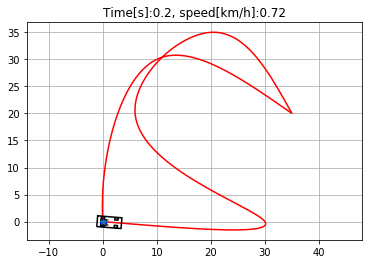

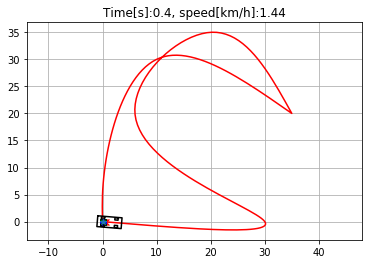

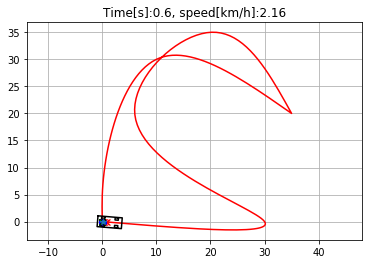

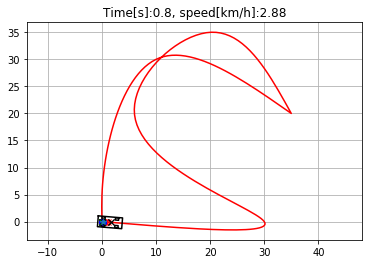

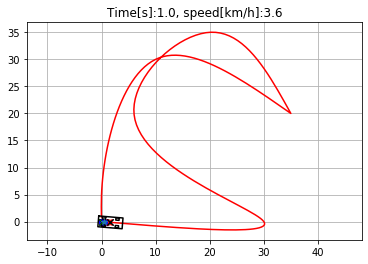

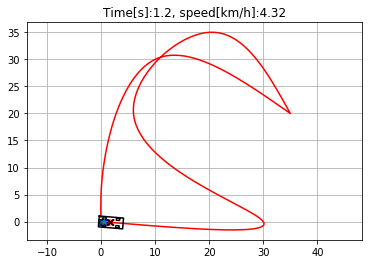

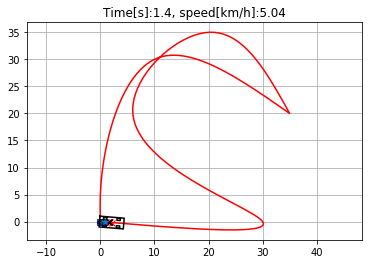

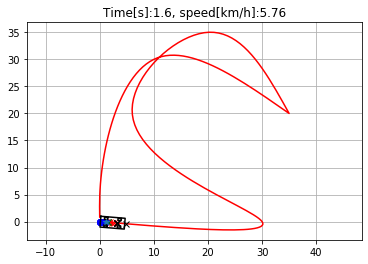

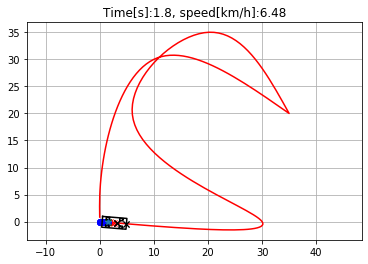

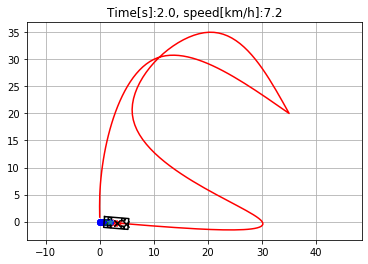

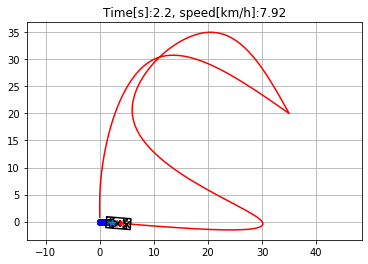

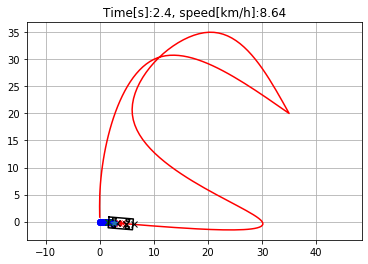

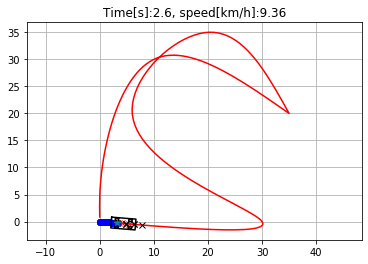

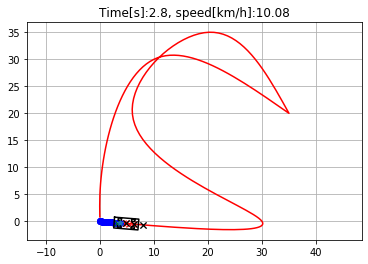

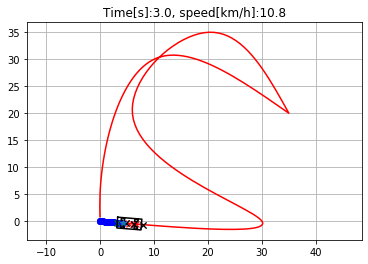

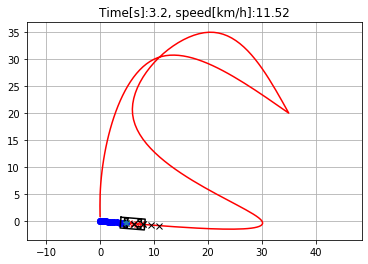

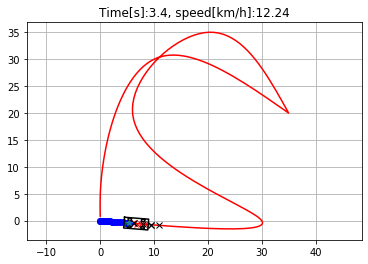

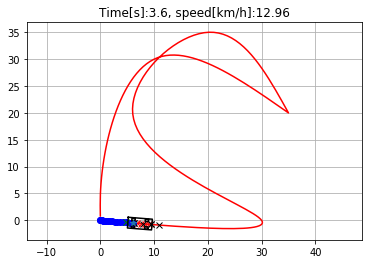

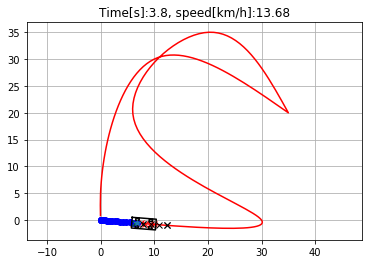

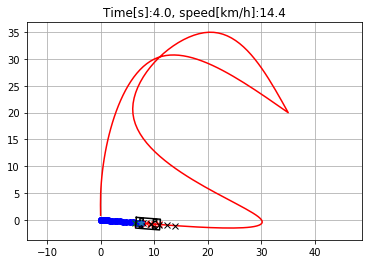

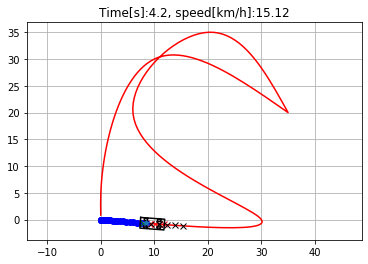

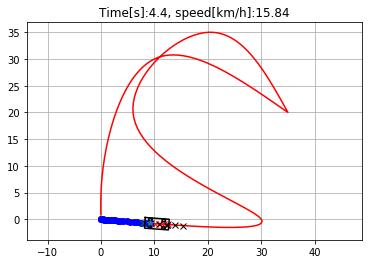

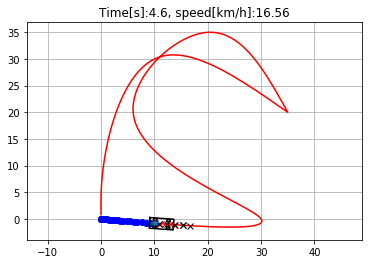

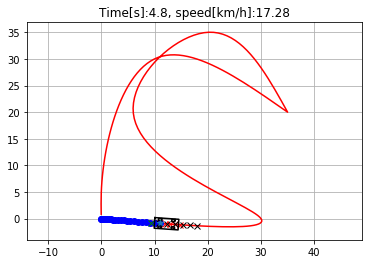

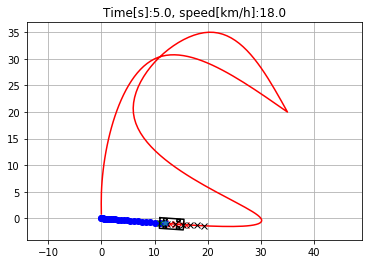

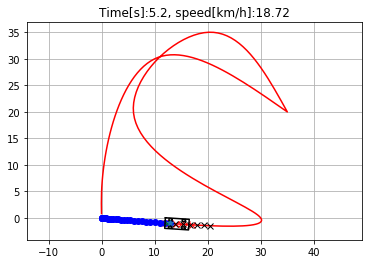

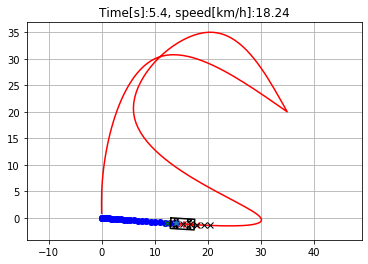

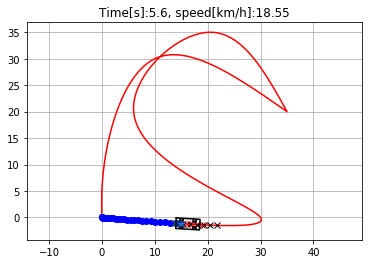

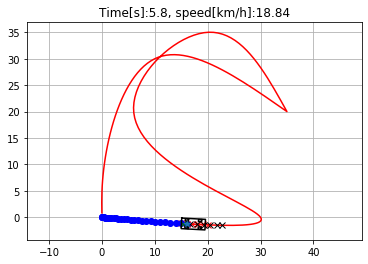

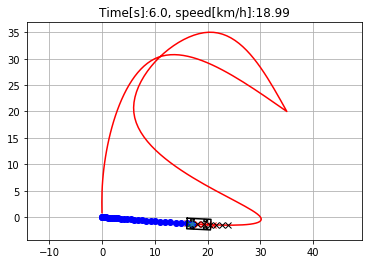

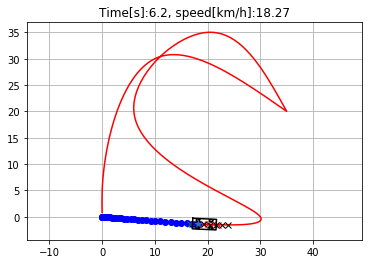

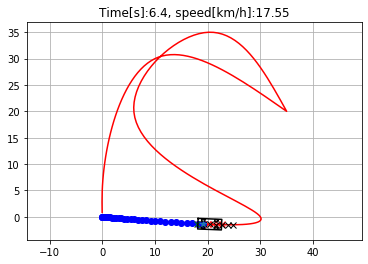

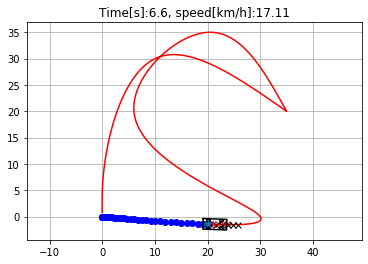

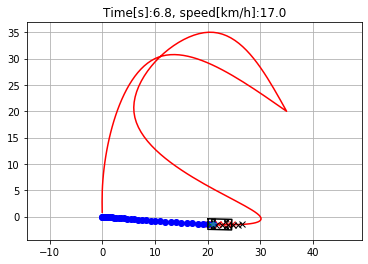

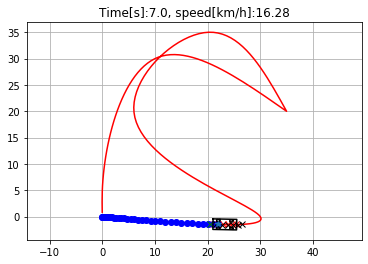

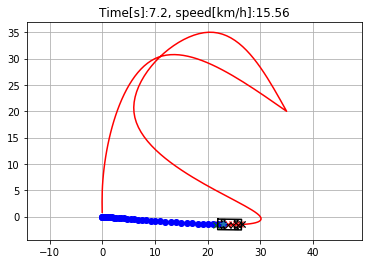

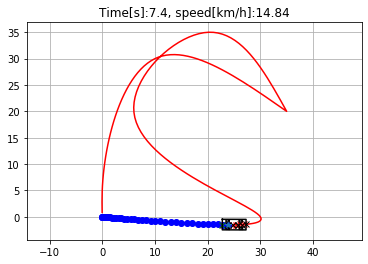

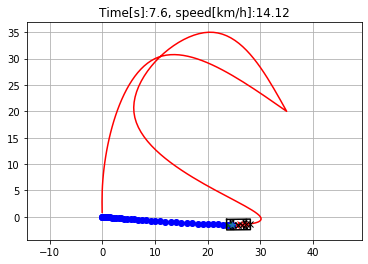

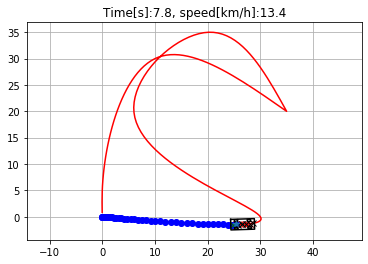

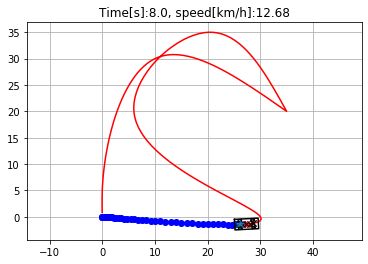

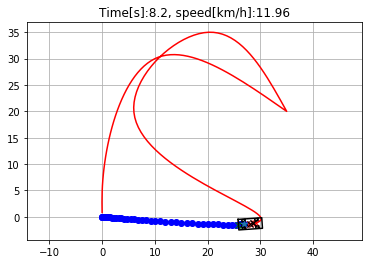

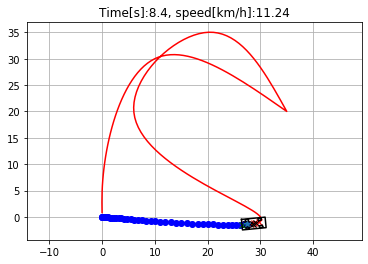

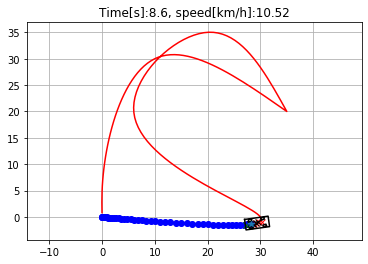

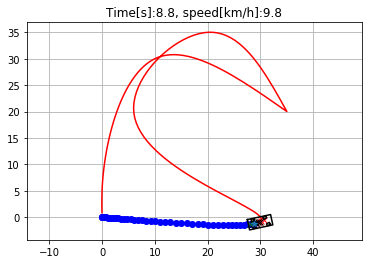

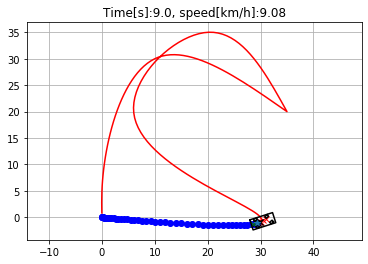

Iterative is max iter


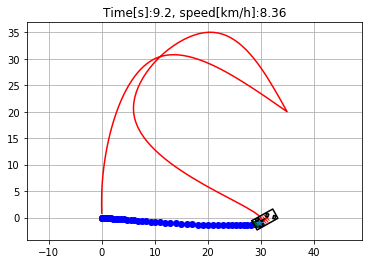

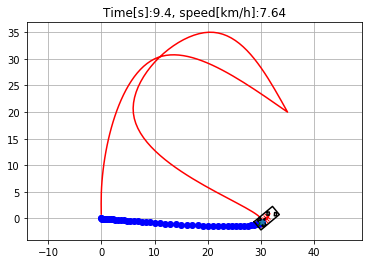

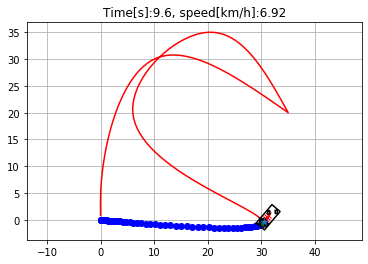

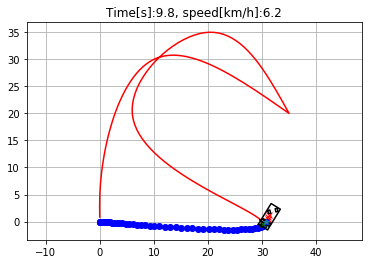

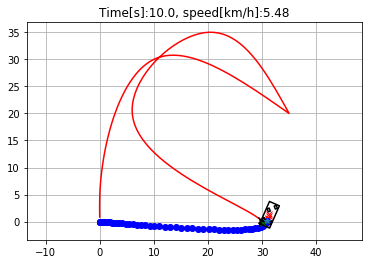

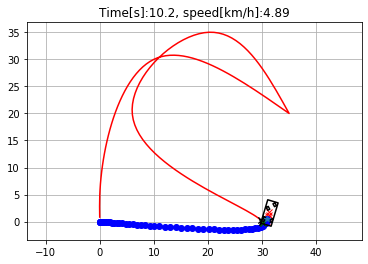

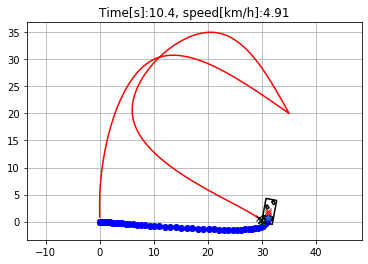

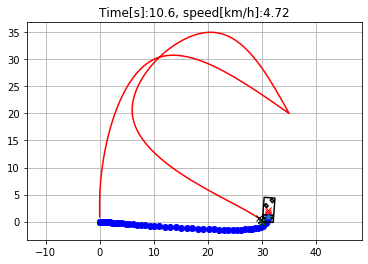

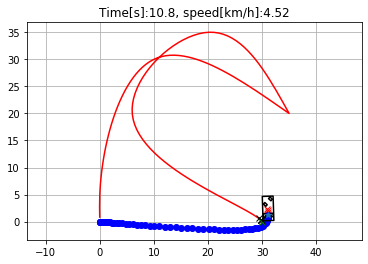

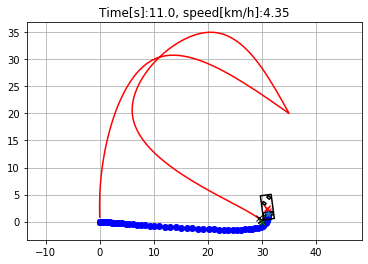

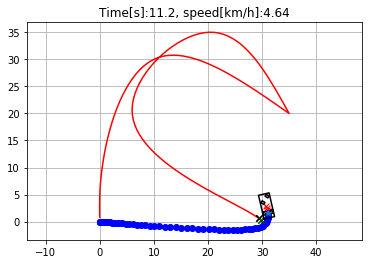

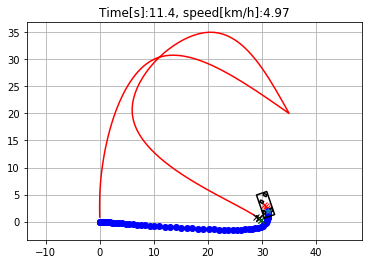

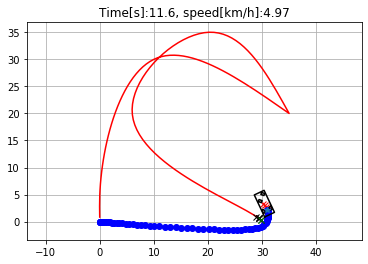

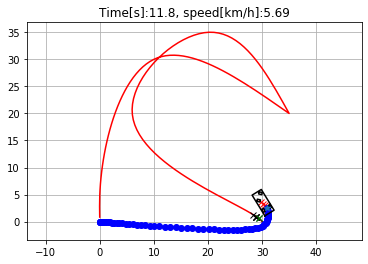

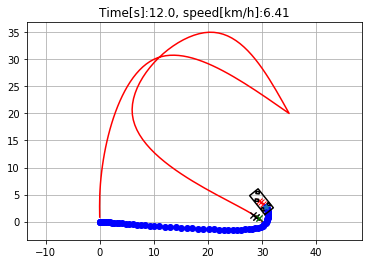

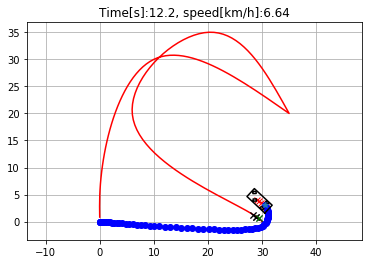

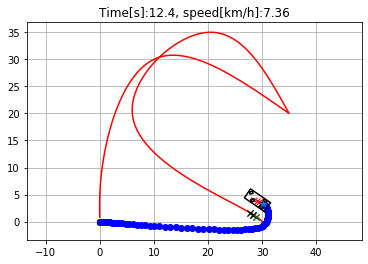

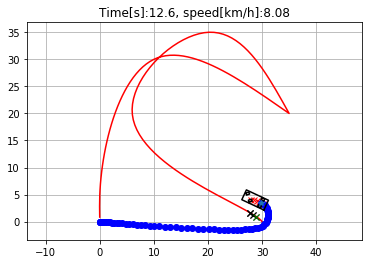

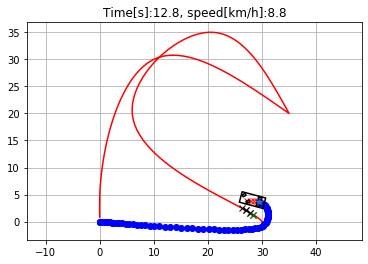

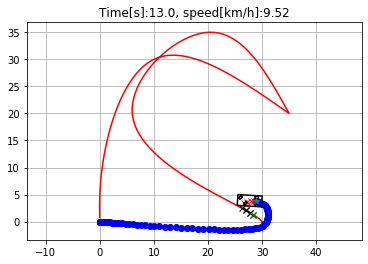

Iterative is max iter


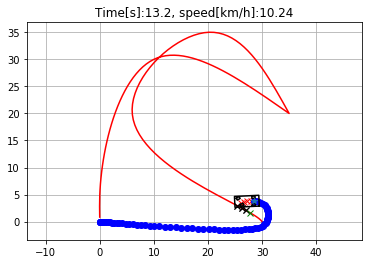

Iterative is max iter


KeyboardInterrupt: 

In [9]:
def do_simulation(cx, cy, cyaw, ck, sp, dl, initial_state):
    """
    Simulation

    cx: course x position list
    cy: course y position list
    cy: course yaw position list
    ck: course curvature list
    sp: speed profile
    dl: course tick [m]

    """

    goal = [cx[-1], cy[-1]]

    state = initial_state

    # initial yaw compensation
    if state.yaw - cyaw[0] >= math.pi:
        state.yaw -= math.pi * 2.0
    elif state.yaw - cyaw[0] <= -math.pi:
        state.yaw += math.pi * 2.0

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    d = [0.0]
    a = [0.0]
    target_ind, _ = calc_nearest_index(state, cx, cy, cyaw, 0)

    odelta, oa = None, None

    cyaw = smooth_yaw(cyaw)

    while MAX_TIME >= time:
        xref, target_ind, dref = calc_ref_trajectory(
            state, cx, cy, cyaw, ck, sp, dl, target_ind)

        x0 = [state.x, state.y, state.v, state.yaw]  # current state

        oa, odelta, ox, oy, oyaw, ov = iterative_linear_mpc_control(
            xref, x0, dref, oa, odelta)

        if odelta is not None:
            di, ai = odelta[0], oa[0]

        state = update_state(state, ai, di)
        time = time + DT

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)
        d.append(di)
        a.append(ai)

        if check_goal(state, goal, target_ind, len(cx)):
            print("Goal")
            break

        if show_animation:  # pragma: no cover
            plt.cla()
            if ox is not None:
                plt.plot(ox, oy, "xr", label="MPC")
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(x, y, "ob", label="trajectory")
            plt.plot(xref[0, :], xref[1, :], "xk", label="xref")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plot_car(state.x, state.y, state.yaw, steer=di)
            plt.axis("equal")
            plt.grid(True)
            plt.title("Time[s]:" + str(round(time, 2))
                      + ", speed[km/h]:" + str(round(state.v * 3.6, 2)))
            plt.pause(0.0001)

    return t, x, y, yaw, v, d, a


def calc_speed_profile(cx, cy, cyaw, target_speed):

    speed_profile = [target_speed] * len(cx)
    direction = 1.0  # forward

    # Set stop point
    for i in range(len(cx) - 1):
        dx = cx[i + 1] - cx[i]
        dy = cy[i + 1] - cy[i]

        move_direction = math.atan2(dy, dx)

        if dx != 0.0 and dy != 0.0:
            dangle = abs(pi_2_pi(move_direction - cyaw[i]))
            if dangle >= math.pi / 4.0:
                direction = -1.0
            else:
                direction = 1.0

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

    speed_profile[-1] = 0.0

    return speed_profile


def smooth_yaw(yaw):

    for i in range(len(yaw) - 1):
        dyaw = yaw[i + 1] - yaw[i]

        while dyaw >= math.pi / 2.0:
            yaw[i + 1] -= math.pi * 2.0
            dyaw = yaw[i + 1] - yaw[i]

        while dyaw <= -math.pi / 2.0:
            yaw[i + 1] += math.pi * 2.0
            dyaw = yaw[i + 1] - yaw[i]

    return yaw


def get_straight_course(dl):
    ax = [0.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0]
    ay = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)

    return cx, cy, cyaw, ck


def get_straight_course2(dl):
    ax = [0.0, -10.0, -20.0, -40.0, -50.0, -60.0, -70.0]
    ay = [0.0, -1.0, 1.0, 0.0, -1.0, 1.0, 0.0]
    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)

    return cx, cy, cyaw, ck


def get_straight_course3(dl):
    ax = [0.0, -10.0, -20.0, -40.0, -50.0, -60.0, -70.0]
    ay = [0.0, -1.0, 1.0, 0.0, -1.0, 1.0, 0.0]
    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)

    cyaw = [i - math.pi for i in cyaw]

    return cx, cy, cyaw, ck


def get_forward_course(dl):
    ax = [0.0, 60.0, 125.0, 50.0, 75.0, 30.0, -10.0]
    ay = [0.0, 0.0, 50.0, 65.0, 30.0, 50.0, -20.0]
    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)

    return cx, cy, cyaw, ck


def get_switch_back_course(dl):
    ax = [0.0, 30.0, 6.0, 20.0, 35.0]
    ay = [0.0, 0.0, 20.0, 35.0, 20.0]
    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)
    ax = [35.0, 10.0, 0.0, 0.0]
    ay = [20.0, 30.0, 5.0, 0.0]
    cx2, cy2, cyaw2, ck2, s2 = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)
    cyaw2 = [i - math.pi for i in cyaw2]
    cx.extend(cx2)
    cy.extend(cy2)
    cyaw.extend(cyaw2)
    ck.extend(ck2)

    return cx, cy, cyaw, ck


def main():
    #print(__file__ + " start!!")

    dl = 1.0  # course tick
    #cx, cy, cyaw, ck = get_straight_course(dl)
    # cx, cy, cyaw, ck = get_straight_course2(dl)
    # cx, cy, cyaw, ck = get_straight_course3(dl)
    # cx, cy, cyaw, ck = get_forward_course(dl)
    cx, cy, cyaw, ck = get_switch_back_course(dl)

    sp = calc_speed_profile(cx, cy, cyaw, TARGET_SPEED)

    initial_state = State(x=cx[0], y=cy[0], yaw=cyaw[0], v=0.0)

    t, x, y, yaw, v, d, a = do_simulation(
        cx, cy, cyaw, ck, sp, dl, initial_state)

    if show_animation:  # pragma: no cover
        plt.close("all")
        plt.subplots()
        plt.plot(cx, cy, "-r", label="spline")
        plt.plot(x, y, "-g", label="tracking")
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()

        plt.subplots()
        plt.plot(t, v, "-r", label="speed")
        plt.grid(True)
        plt.xlabel("Time [s]")
        plt.ylabel("Speed [kmh]")

        plt.show()


def main2():
    print(__file__ + " start!!")

    dl = 1.0  # course tick
    cx, cy, cyaw, ck = get_straight_course3(dl)

    sp = calc_speed_profile(cx, cy, cyaw, TARGET_SPEED)

    initial_state = State(x=cx[0], y=cy[0], yaw=0.0, v=0.0)

    t, x, y, yaw, v, d, a = do_simulation(
        cx, cy, cyaw, ck, sp, dl, initial_state)

    if show_animation:  # pragma: no cover
        plt.close("all")
        plt.subplots()
        plt.plot(cx, cy, "-r", label="spline")
        plt.plot(x, y, "-g", label="tracking")
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()

        plt.subplots()
        plt.plot(t, v, "-r", label="speed")
        plt.grid(True)
        plt.xlabel("Time [s]")
        plt.ylabel("Speed [kmh]")

        plt.show()


if __name__ == '__main__':
    main()
    # main2()